In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

In [ ]:

import os
import re
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import ast

DATA_PATH = Path('/content/drive/MyDrive/Colab Notebooks/df.csv')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



In [ ]:
df = pd.read_csv(DATA_PATH, sep=',')
import json
json_file_path = '/content/drive/MyDrive/Colab Notebooks/unified_skills_mappings.json'
try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        skills_data = json.load(f)
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути '{json_file_path}'")
    skills_data = {}

SKILL_MAP_FROM_JSON = {}

for original_skill, details in skills_data.items():
    key = original_skill.lower()

    value = details.get('unified_skill', original_skill).lower()

    SKILL_MAP_FROM_JSON[key] = value

print(f"Загружено и обработано {len(SKILL_MAP_FROM_JSON)} правил из JSON.")
for i, (k, v) in enumerate(SKILL_MAP_FROM_JSON.items()):
    if i >= 5: break
    print(f"'{k}'  ->  '{v}'")




Загружено и обработано 2487 правил из JSON.
'1c document management'  ->  'работа с системами управления документами 1с'
'1c erp'  ->  'владение системой 1с:erp'
'1c software proficiency'  ->  'владение программным обеспечением 1с'
'1c упп'  ->  'работа с программным обеспечением 1с: управление производственным предприятием'
'1c: accounting'  ->  'владение программным обеспечением 1с: бухгалтерия'


In [ ]:
print(f"Исходный размер df: {df.shape}")

duplicates_in_df = df.columns[df.columns.duplicated()]
if not duplicates_in_df.empty:
    print("\n!!! ОБНАРУЖЕНЫ ДУБЛИКАТЫ КОЛОНОК В ИСХОДНОМ ФАЙЛЕ df !!!")
    print("Дублирующиеся имена:", duplicates_in_df.unique().tolist())

    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    print(f"\nДубликаты удалены. Новый размер df: {df.shape}")
else:
    print("\nДублирующихся колонок в исходном df не найдено.")


Исходный размер df: (7585, 95)

Дублирующихся колонок в исходном df не найдено.


In [ ]:
MANUAL_SKILL_MAP = {

    # --- Группа "Налоговый учет" ---
    'знание налогового учета': 'налоговый учет',
    'ведение налогового учета': 'налоговый учет',

    # --- Группа "ПК" ---
    'владение компьютерная техника/оборудование': 'навыки работы с пк',
    'владение/пользователь пк': 'навыки работы с пк',
    'знание компьютерных и прочих программ': 'навыки работы с пк',
    'навыки работы с персональным компьютером': 'навыки работы с пк',

    # --- Группа "Зарплата" ---
    'расчет и начисление заработной платы': 'расчет заработной платы',

    # --- Группа "Первичка" ---
    'ведение первичной документации': 'работа с первичной документацией',
    'обработка первичной документации': 'работа с первичной документацией',
    'первичная бухгалтерия': 'работа с первичной документацией',

    # --- Группа "Бух. учет" ---
    'знание бухгалтерского учета': 'бухгалтерский учет',
    'ведение бухгалтерского учета': 'бухгалтерский учет',
    'организация бухгалтерского учета': 'бухгалтерский учет',
    'опыт работы бухгалтером': 'бухгалтерский учет', # Можно и так обобщить

    # --- Группа "ТМЦ" ---
    'анализ тмц': 'учет тмц',
    'движение/перемещение тмц': 'учет тмц',
    'инвентаризация тмц': 'учет тмц',
    'комплектация тмц': 'учет тмц',

    # --- Группа "НМА" ---
    'амортизация нма': 'учет нма',
    'инвентаризация нма': 'учет нма',

    # --- Группа "Затраты" ---
    'анализ затрат': 'управление затратами',
    'оптимизация затрат': 'управление затратами',
    'нормирование затрат': 'управление затратами',
    'планирование затрат': 'управление затратами',

    # --- Упрощение неопределенных сокращений ---
    'зна': 'знания', # Или можно просто удалить, если это мусор
    'компь': 'навыки работы с пк',
    'бух': 'бухгалтерия',

}

In [ ]:
import re
import pandas as pd
from collections import defaultdict

SKILL_GROUP_PATTERNS = {
    '1c': [
        r'\b1c\b', r'\b1c[:\s-]?(предпр|бухгалтер|зуп|унф|ут)\b',
        r'программ\w*\s*1c', r'использ\w*\s*1c', r'владен\w*\s*1c', r'работ\w*\s*1c',
        r'ввод.*\b1c\b'
    ],
    'excel': [
        r'\bexcel\b', r'мicrosoft excel', r'ms excel', r'сводн\w*\s*табл'
    ],
    'навыки работы с пк': [
        r'\bпк\b', r'персональн\w*\s*компьют', r'компьютерн\w*\s*навы',
        r'компьютерн\w*\s*грам', r'офисн\w*\s*програм', r'пакет\s*microsoft\s*office',
        r'владен\w*\s*офисн\w*\s*програм', r'использ\w*\s*персональн\w*\s*компьют'
    ],
    'бухучет: организация': [
        r'организац\w*\s*бухгалтерск\w*\s*учет',
        r'постановк\w*\s*учет',
        r'учетн\w*\s*политик',
        r'методолог\w*\s*учет',
        r'регламент\w*\s*учет'
    ],
    'бухучет: ведение': [
        r'веден\w*\s*бухгалтерск\w*\s*учет',
        r'веден\w*\s*учет\w*\s*финан\w*[- ]*хоз',
        r'учет\w*\s*финан\w*[- ]*хоз',
        r'первичн\w*\s*документ',
        r'учет\w*\s*первичн',
        r'учет\w*\s*материал',
        r'учет\w*\s*тмц',
        r'учет\w*\s*осн\w*\s*сред'
    ],
    'налоговый учет': [
        r'налогов\w*\s*учет'
    ],
    'налоговая отчетность': [
        r'налогов\w*\s*отчетн', r'налогов\w*\s*декларац', r'подготов\w*\s*налогов\w*\s*декларац'
    ],
    'финансовая/бухгалтерская отчетность': [
        r'финанц\w*\s*отчетн', r'бухгалтерск\w*\s*отчетн'
    ],
    'документооборот': [
        r'документооборот', r'делопроизвод', r'ведение\s*документац',
        r'электронн\w*\s*документооборот', r'управлен\w*\s*документац'
    ],
    'клиент-банк': [
        r'банк-?клиент', r'клиент-?банк', r'систем\w*\s*клиент-?банк'
    ],
    'взаиморасчеты с контрагентами': [
        r'взаиморасчет\w*\s*с\s*контрагент', r'сверк\w*\s*с\s*контрагент',
        r'акты\s*свер[оа]к', r'учет\w*\s*расчет\w*\s*с\s*контрагент',
        r'расчет\w*\s*с\s*поставщик', r'расчет\w*\s*с\s*дебитор', r'расчет\w*\s*с\s*кредитор'
    ],
    'зарплата/кадры': [
        r'заработн\w*\s*плат', r'\bзп\b', r'начислен\w*\s*зарплат', r'расчет\w*\s*заработ'
    ],
    'бюджетирование': [
        r'бюджетир\w*', r'составлен\w*\s*бюджет', r'планирован\w*\s*бюджет',
        r'планирован\w*\s*и\s*контрол\w*\s*расход'
    ],
}

def build_group_to_cols(skills_df: pd.DataFrame, patterns_map: dict) -> dict:
    group_to_cols = {}
    cols = list(skills_df.columns)
    for canon, pats in patterns_map.items():
        found = set()
        for pat in pats:
            rx = re.compile(pat, flags=re.IGNORECASE)
            for c in cols:
                if rx.search(c):
                    found.add(c)
        group_to_cols[canon] = sorted(found)
    return group_to_cols

def collapse_skills(skills_df: pd.DataFrame, group_to_cols: dict) -> pd.DataFrame:
    out = skills_df.copy()
    to_drop = set()
    for canon, cols in group_to_cols.items():
        if not cols:
            continue
        out[canon] = (out[cols].sum(axis=1) > 0).astype(int)
        for c in cols:
            if c != canon:
                to_drop.add(c)
    to_drop = [c for c in to_drop if c in out.columns]
    out = out.drop(columns=to_drop)
    print(f"Схлопнуто групп: {sum(len(v)>0 for v in group_to_cols.values())}, удалено колонок: {len(to_drop)}")
    return out

In [ ]:
GENERIC_SOFT_PATTERNS = [
    r'дружелюб', r'доброжел', r'активн', r'стрессоусто',
    r'ответственн', r'внимател', r'исполнител', r'дисциплин',
    r'пунктуал', r'работоспособ', r'организован', r'обучаем',
    r'командн\w*\s*работ', r'межличност', r'грамотн\w*\s*реч',
    r'устн\w*\s*коммуникац', r'письменн\w*\s*коммуникац',
    r'вежлив', r'тактич', r'толерант', r'аккурат', r'трудолюб',
    r'ориентир\w*\s*на\s*результ', r'готовност\w*\s*к\s*обучен',
    r'коммуникативн', r'креативн', r'гибк', r'адаптив',
    r'инициатив', r'позитивн', r'мотивац', r'лидерств'
]
DO_COLLAPSE = True
COLLAPSE_KEEP = ['1c', 'клиент-банк', 'взаиморасчеты с контрагентами', 'налоговая отчетность', 'зарплата/кадры', 'бюджетирование']

OFFICE_BASIC_PATTERNS = [
    r'\bword\b', r'microsoft\s*word', r'\bms\s*word\b',
    r'outlook', r'microsoft\s*outlook',
    r'электронн\w*\s*почт', r'\bemail\b', r'e-?mail',
    r'\binternet\b', r'интернет', r'браузер'
]

def drop_generic_soft(skills_df: pd.DataFrame):
    pats = GENERIC_SOFT_PATTERNS + OFFICE_BASIC_PATTERNS
    rx = re.compile('(?:' + '|'.join(pats) + ')', flags=re.IGNORECASE)
    cols_to_drop = [c for c in skills_df.columns if rx.search(c)]
    kept = skills_df.drop(columns=cols_to_drop, errors='ignore')
    print(f"Удалены soft/office-basic: {len(cols_to_drop)} колонок")
    return kept, cols_to_drop


def filter_rare_skills(skills_df: pd.DataFrame, min_count: int = 5):
    counts = skills_df.sum(axis=0)
    keep = counts[counts >= min_count].index
    dropped = [c for c in skills_df.columns if c not in keep]
    print(f"Отброшены редкие навыки (<{min_count}): {len(dropped)} колонок")
    return skills_df[keep]

In [ ]:
def normalize_skill(text: str) -> str:
    s = str(text).lower().strip()

    s = re.sub(r'1[сc]', '1c', s)

    s = re.sub(r'\s+', ' ', s)
    s = s.strip(' "\'«».,;:|')

    if s in SKILL_MAP_FROM_JSON:
        s = SKILL_MAP_FROM_JSON[s]
    elif s in MANUAL_SKILL_MAP:
        s = MANUAL_SKILL_MAP[s]
    return s
def to_list_safe(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s in ("", "[]", "{}", "nan", "None"):
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except Exception:
        return re.split(r'[;\n\r|]+', s)


def explode_item(item: str):
    text = str(item)

    text = re.sub(r'на основе\s*esco\s*taxonomy:.*', '', text, flags=re.IGNORECASE)

    text = re.sub(r'\s+[—\-–]\s+', ' | ', text)

    text = re.sub(r'\s+\d{1,2}[.)]\s+', ' | ', text)
    text = re.sub(r'^\s*\d{1,2}[.)]\s+', '', text)

    text = re.sub(r'[;\n\r]+', ' | ', text)

    text = re.sub(r'\s*\|\s*', ' | ', text)
    parts = [p.strip() for p in text.split(' | ') if p.strip()]
    return parts


def clean_and_parse_skills(row):
    skill_source_columns = [
        'skills_vacancy', 'hardSkills_vacancy', 'softSkills_vacancy',
        'standardize_skills_cv', 'combined_skills'
    ]
    raw_items = []
    for col in skill_source_columns:
        if col not in row.index:
            continue
        vals = row[col]
        seq = vals if isinstance(vals, list) else to_list_safe(vals)
        for it in seq:
            raw_items.extend(explode_item(it))

    skills = []
    for t in raw_items:
        t = normalize_skill(t)
        if not t:
            continue
        if len(t) < 2 or re.fullmatch(r'\d+', t):
            continue
        skills.append(t)

    return sorted(set(skills))

In [ ]:
df["salary"] = df[["salaryMin_vacancy", "salaryMax_vacancy"]].mean(axis=1, skipna=True)
df = df[df["salary"].notna() & (df["salary"] > 0)].copy()

df['skills_list_clean'] = df.apply(clean_and_parse_skills, axis=1)
print("\nТип первого элемента в skills_list_clean:", type(df['skills_list_clean'].iloc[0]))
display(df[['standardize_skills_cv', 'skills_list_clean']].head())



Тип первого элемента в skills_list_clean: <class 'list'>


,standardize_skills_cv,skills_list_clean
0,['1. Ответственность\n2. Инициативность\n3. До...,[владение бухгалтерским программным обеспечени...
1,['B'],[ведение бухгалтерского учета в государственно...
2,['B'],[неопределенный навык]
3,[],[]
4,[],"[навыки работы с компьютером, ответственность ..."


In [ ]:

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom))

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def detect_target(df):
    candidates = ['salaryMin_vacancy', 'salary_rub', 'salary_from_rub', 'target']
    for c in candidates:
      print(c, df.columns)
      if c in df.columns:
        return c
    # fall back to last numeric
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise ValueError("No numeric columns found for target detection.")
    return num_cols[-1]

def detect_skills_col(df):
    candidates = ['skills', 'skills_list', 'competencies', 'combined_skills']
    for c in candidates:
        if c in df.columns.tolist():
            return c
    return None

def remove_skill_from_text(text, skill):
    if not isinstance(text, str):
        return text
    # Remove whole-word occurrences (case-insensitive)
    pattern = r'(?i)(?<!\w)' + re.escape(skill) + r'(?!\w)'
    return re.sub(pattern, ' ', text)

def add_skill_to_text(text, skill, sep=', '):
    text = '' if not isinstance(text, str) else text.strip()
    toks = [t.strip() for t in re.split(r'[;,]', text) if t.strip()]
    if skill not in toks:
        toks.append(skill)
    return sep.join(sorted(set(toks)))


In [ ]:
display(df.head(3))


,Unnamed: 0,idCv,idVacancy,cv_status,locality,localityName,birthday,gender,age,positionName,...,addressCode,addressOffice,medicalDocument,benefit,conditions,combined_skills_cv,skills_len,standardize_skills_cv,salary,skills_list_clean
0,12,6852acb0-822a-11ee-a96f-c7bd3a8c3ec7,b4f4ddb9-b3ab-11ee-96a1-e7d0d2cf29b1,Отказ,4.701100e+12,"Ленинградская-область,-Лодейнопольский-район,-...",1973-11-26T15:00:00+0300,Женский,51.0,Главный-бухгалтер-государственного-муниципальн...,...,1.000200e+16,NaN,NaN,NaN,NaN,"['Ответственность\xa0, добросовестность', 'Ини...",25,['1. Ответственность\n2. Инициативность\n3. До...,36000.0,[владение бухгалтерским программным обеспечени...
1,23,d30d6ee0-a90e-11e9-bc05-037acc02728d,64be5855-25e4-11ec-bd96-93a84dada081,Отказ,5.900001e+12,"Пермский-край,-г-Соликамск",1976-06-04T15:00:00+0300,Женский,48.0,Бухгалтер,...,5.900001e+16,NaN,NaN,NaN,Оптимальные,['B'],1,['B'],28500.0,[ведение бухгалтерского учета в государственно...
2,53,b7d000d0-e5f2-11ea-9826-6db06c9eaf56,884bff48-59fb-11ef-8ab6-d549be31d974,Отказ,5.900000e+12,"Пермский-край,-г-Пермь",1978-07-28T15:00:00+0300,Женский,46.0,Бухгалтер,...,5.900000e+16,NaN,NaN,NaN,NaN,['B'],1,['B'],17500.0,[неопределенный навык]


In [ ]:
df["salaryMin_vacancy"]

,salaryMin_vacancy
0,72000.0
1,28000.0
2,0.0
3,22440.0
4,25000.0
...,...
7580,25000.0
7581,25806.0
7582,84882.0
7583,51000.0


In [ ]:
df.columns

Index(['Unnamed: 0', 'idCv', 'idVacancy', 'cv_status', 'locality',
       'localityName', 'birthday', 'gender', 'age', 'positionName',
       'dateCreate', 'typicalPosition_cv', 'dateModify_cv', 'publishedDate',
       'academicDegree', 'skills_cv', 'driveLicenses', 'experience',
       'otherCertificates', 'country', 'educationList', 'hardSkills_cv',
       'softSkills_cv', 'workExperienceList', 'scheduleType_cv', 'salary_cv',
       'retrainingCapability_cv', 'businessTrip', 'languageKnowledge_cv',
       'relocation', 'innerInfo', 'salaryMin_cv', 'salaryMax_cv', 'education',
       'id_vacancy', 'stateRegionCode_vacancy', 'vacancyName',
       'codeProfession', 'codeProfessionalSphere', 'professionalSphereName',
       'vacancyAddress', 'vacancyAddressHouse', 'vacancyAddressAdditionalInfo',
       'geo', 'salary_vacancy', 'languageKnowledge_vacancy',
       'busyType_vacancy', 'educationRequirements', 'hardSkills_vacancy',
       'softSkills_vacancy', 'skills_vacancy', 'typicalPosit

In [ ]:
df['region'] = df['localityName'].fillna('Не указан')
print(f"Количество уникальных регионов: {df['region'].nunique()}")
df['date_published'] = pd.to_datetime(df['datePublished'], errors='coerce')
df['year_published'] = df['date_published'].dt.year
df['month_published'] = df['date_published'].dt.month
df['day_of_week_published'] = df['date_published'].dt.dayofweek
df['isQuoted'] = df['isQuoted'].fillna(False).astype(int)
df['isMobilityProgram'] = df['isMobilityProgram'].fillna(False).astype(int)
df['scheduleType_vacancy'] = df['scheduleType_vacancy'].astype('category').cat.codes
df['companyBusinessSize'] = df['companyBusinessSize'].astype('category').cat.codes
df['needMedcard'] = df['needMedcard'].astype('category').cat.codes

Количество уникальных регионов: 609


/tmp/ipython-input-199787840.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isMobilityProgram'] = df['isMobilityProgram'].fillna(False).astype(int)


In [ ]:
df['region'] = df['localityName'].fillna('Не указан')
print(f"Количество уникальных регионов: {df['region'].nunique()}")
df['date_published'] = pd.to_datetime(df['datePublished'], errors='coerce')
df['year_published'] = df['date_published'].dt.year
df['month_published'] = df['date_published'].dt.month
df['day_of_week_published'] = df['date_published'].dt.dayofweek

Количество уникальных регионов: 609


In [ ]:
df = df[df['skills_vacancy'].apply(lambda x: x != '[]' if pd.notna(x) else False)].copy()
def combine_skills(row):
    skills = []
    if pd.notna(row['skills_vacancy']) and row['skills_vacancy'] != '[]':
        skills.extend(eval(row['skills_vacancy']))
    if pd.notna(row['hardSkills_vacancy']) and row['hardSkills_vacancy'] != '[]':
        skills.extend(eval(row['hardSkills_vacancy']))
    if pd.notna(row['softSkills_vacancy']) and row['softSkills_vacancy'] != '[]':
        skills.extend(eval(row['softSkills_vacancy']))

    combined_skills = list(set([skill.lower() for skill in skills]))
    return combined_skills

df['combined_skills'] = df.apply(combine_skills, axis=1)

display(df[['skills_vacancy', 'hardSkills_vacancy', 'softSkills_vacancy', 'combined_skills']].head())

,skills_vacancy,hardSkills_vacancy,softSkills_vacancy,combined_skills
1,"[""Навыки работы с компьютерными офисными прогр...",[],[],[знание законодательства по бухгалтерскому уче...
4,"[""Ответственность , добросовестность"", ""Знание...",[],[],"[ответственность , добросовестность, знание ра..."
14,"[""Руководство бухгалтерией"", ""Подписание докум...",[],[],"[исполнение приказов, подписание документации,..."
15,"[""Ответственность , добросовестность"", ""Знание...",[],[],"[ответственность , добросовестность, знание ра..."
24,"[""Знание работы с компьютером"", ""Знание законо...",[],[],[работа в системе электронного документооборот...


In [ ]:
vacancy_columns = [
    'vacancyName', 'experienceRequirements', 'scheduleType_vacancy', 'needMedcard',
    'requiredDriveLicense', 'companyBusinessSize', 'isQuoted', 'isMobilityProgram',
    'qualifications', 'responsibilities', 'year_published',
    'month_published', 'day_of_week_published'
]
# 'combined_skills' и таргет 'salaryMin_vacancy' здесь не нужны, мы их обработаем отдельно

existing_core_cols = [col for col in vacancy_columns if col in df.columns]
X = df[existing_core_cols].copy()
print("Обработка и нормализация навыков...")
X['skills_list_clean'] = df.apply(clean_and_parse_skills, axis=1)
print("Готово.")



Обработка и нормализация навыков...
Готово.


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin

skills_col = 'skills_list_clean'
mlb = MultiLabelBinarizer(sparse_output=False)

skills_binarized = mlb.fit_transform(X[skills_col])
skills_df = pd.DataFrame(skills_binarized, columns=mlb.classes_, index=X.index)


if DO_COLLAPSE:
    group_to_cols_full = build_group_to_cols(skills_df, SKILL_GROUP_PATTERNS)
    group_to_cols_sel = {k: v for k, v in group_to_cols_full.items() if k in COLLAPSE_KEEP}
    skills_df_use = collapse_skills(skills_df, group_to_cols_sel)
else:
    skills_df_use = skills_df.copy()
    print("Схлопывание выключено (используем сырые навыки после нормализации).")
skills_df_use, _ = drop_generic_soft(skills_df_use)

skills_df_use = filter_rare_skills(skills_df_use, min_count=10)  # можно поиграть 5/10/20

skill_cols = skills_df_use.columns.tolist()

X_base = X.drop(columns=[skills_col], errors='ignore')

raw_skill_columns_to_drop = ['combined_skills', 'skills_vacancy', 'hardSkills_vacancy', 'softSkills_vacancy', 'standardize_skills_cv']

existing_raw_to_drop = [col for col in raw_skill_columns_to_drop if col in X_base.columns]

if existing_raw_to_drop:
    X_base = X_base.drop(columns=existing_raw_to_drop)
    print(f"Удалены сырые колонки с навыками: {existing_raw_to_drop}")


X_processed = pd.concat([X_base, skills_df_use], axis=1)

base_feature_columns = [c for c in X_processed.columns if c not in skill_cols]

display(X_processed.head())

Схлопнуто групп: 6, удалено колонок: 103
Удалены soft/office-basic: 64 колонок
Отброшены редкие навыки (<10): 590 колонок


,vacancyName,experienceRequirements,scheduleType_vacancy,needMedcard,requiredDriveLicense,companyBusinessSize,isQuoted,isMobilityProgram,qualifications,responsibilities,...,управление электронным документооборотом,учет тмц,финансовый анализ,"формирование, расчет и калькулирование себестоимости продукции, т.р.у",экономический анализ,эксплуатация офисного оборудования,налоговая отчетность,клиент-банк,зарплата/кадры,бюджетирование
1,Ведущий специалист,3.0,1,1,[],4,0,0,Умение пользоваться компьютерными программами ...,"Ведение бухгалтерского и налогового учета, сос...",...,0,0,0,0,0,0,0,0,0,0
4,Специалист,0.0,3,1,[],2,0,0,Порядок составления планово-отчетной документа...,Осуществляет взаимодействие со структурными по...,...,0,0,0,0,0,0,0,0,0,0
14,Главный бухгалтер,1.0,3,1,[],4,0,0,"Знание программ ""1С.Бухгалтерия 8.3"" и 1С.""Кам...",Осуществляет бухгалтерский учет финансово-хозя...,...,1,0,0,0,0,0,0,0,0,0
15,Специалист,0.0,3,1,[],2,0,0,Порядок составления планово-отчетной документа...,Осуществляет взаимодействие со структурными по...,...,0,0,0,0,0,0,0,0,0,0
24,Заместитель главного бухгалтера,5.0,3,1,[],3,0,0,Образование высшее (экономическое) Опыт работы...,Ведение бухгалтерского учета Ведение налоговог...,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
target_col = 'salary'
y = df['salary'].loc[X_processed.index]
cat_cols = []
text_cols = []
#base_feature_columns = [col for col in X_processed.columns if col not in mlb.classes_]

for c in base_feature_columns:
    if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):
        avg_tokens = X_processed[c].astype(str).str.split().map(len).mean()
        if avg_tokens is not None and avg_tokens > 10:
            text_cols.append(c)
        else:
            cat_cols.append(c)

print("Категориальные колонки:", cat_cols)
print("Текстовые колонки для TF-IDF:", text_cols)

# Log-transform
USE_LOG_TARGET = True
if USE_LOG_TARGET:
    y_transformed = np.log(np.maximum(y, 1.0))
else:
    y_transformed = y.copy()


Категориальные колонки: ['vacancyName', 'requiredDriveLicense']
Текстовые колонки для TF-IDF: ['qualifications', 'responsibilities']


/tmp/ipython-input-3534230069.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):
/tmp/ipython-input-3534230069.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):
/tmp/ipython-input-3534230069.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_processed, y_transformed, test_size=0.2, random_state=RANDOM_STATE
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vecs = {}
X_train_num = X_train.copy()
X_valid_num = X_valid.copy()

for col in text_cols:
    vec = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=5)
    Xt = vec.fit_transform(X_train[col].fillna(""))
    Xv = vec.transform(X_valid[col].fillna(""))

    tf_cols = [f"{col}__tfidf_{i}" for i in range(Xt.shape[1])]
    X_train_tfidf = pd.DataFrame(Xt.toarray(), index=X_train.index, columns=tf_cols)
    X_valid_tfidf = pd.DataFrame(Xv.toarray(), index=X_valid.index, columns=tf_cols)

    X_train_num = pd.concat([X_train_num.drop(columns=[col]), X_train_tfidf], axis=1)
    X_valid_num = pd.concat([X_valid_num.drop(columns=[col]), X_valid_tfidf], axis=1)
    tfidf_vecs[col] = vec

duplicates = X_train_num.columns[X_train_num.columns.duplicated()]
if not duplicates.empty:
    print("Найдены дублирующиеся колонки:")
    print(duplicates.unique().tolist())
    print("\nПодсчет всех дубликатов:")
    print(X_train_num.columns.value_counts()[X_train_num.columns.value_counts() > 1])
else:
    print("Дублирующихся колонок не найдено.")

Дублирующихся колонок не найдено.


In [ ]:
new_cat_cols = [c for c in cat_cols if c in X_train_num.columns]
new_text_cols = []
new_num_cols  = [c for c in X_train_num.columns if c not in new_cat_cols]

def make_pool_num(X_df, y_vec=None):
    feature_names = list(X_df.columns)
    cat_idxs = [feature_names.index(c) for c in new_cat_cols if c in feature_names]
    return Pool(
        data=X_df,
        label=y_vec,
        cat_features=cat_idxs if cat_idxs else None,
        feature_names=feature_names,
    )

train_pool_num = make_pool_num(X_train_num, y_train)
valid_pool_num = make_pool_num(X_valid_num, y_valid)

# 3) Параметры CatBoost (без text_processing), GPU ОК
from catboost.utils import get_gpu_device_count
gpu_ok = (get_gpu_device_count() > 0)

params = dict(
    loss_function='RMSE',
    depth=8,
    iterations=1200,
    learning_rate=0.045,
    random_seed=RANDOM_STATE,
    od_type='Iter',
    od_wait=50,
    verbose=100,
    task_type='GPU' if gpu_ok else 'CPU'
)

model = CatBoostRegressor(**params)
print(y_train)
model.fit(train_pool_num, eval_set=valid_pool_num)

# Оценка
yhat_valid_t = model.predict(valid_pool_num)
yhat_valid = np.exp(yhat_valid_t) if USE_LOG_TARGET else yhat_valid_t
y_valid_orig = np.exp(y_valid) if USE_LOG_TARGET else y_valid

print("Validation RMSE:", rmse(y_valid_orig, yhat_valid))
print("Validation MAPE:", mape(y_valid_orig, yhat_valid))



7544    11.074421
3258    10.711748
765     10.308953
6672    10.290466
2552    11.002100
          ...    
622     10.868568
2385    11.191342
3444    10.668955
854     10.638256
6285    10.633449
Name: salary, Length: 828, dtype: float64
0:	learn: 0.3835402	test: 0.3771763	best: 0.3771763 (0)	total: 266ms	remaining: 5m 19s
100:	learn: 0.1603638	test: 0.1931714	best: 0.1931714 (100)	total: 19.7s	remaining: 3m 33s
200:	learn: 0.1034971	test: 0.1634930	best: 0.1634930 (200)	total: 29.6s	remaining: 2m 27s
300:	learn: 0.0660037	test: 0.1520527	best: 0.1520527 (300)	total: 37.5s	remaining: 1m 52s
400:	learn: 0.0472254	test: 0.1487091	best: 0.1486367 (399)	total: 47.3s	remaining: 1m 34s
500:	learn: 0.0357802	test: 0.1468312	best: 0.1468254 (499)	total: 56.5s	remaining: 1m 18s
600:	learn: 0.0274643	test: 0.1458070	best: 0.1457852 (597)	total: 1m 5s	remaining: 1m 4s
700:	learn: 0.0215341	test: 0.1453310	best: 0.1453223 (699)	total: 1m 15s	remaining: 53.5s
800:	learn: 0.0176437	test: 0.1452445

Validation RMSE: 8227.200605647535
Validation MAPE: 0.057335832096765064


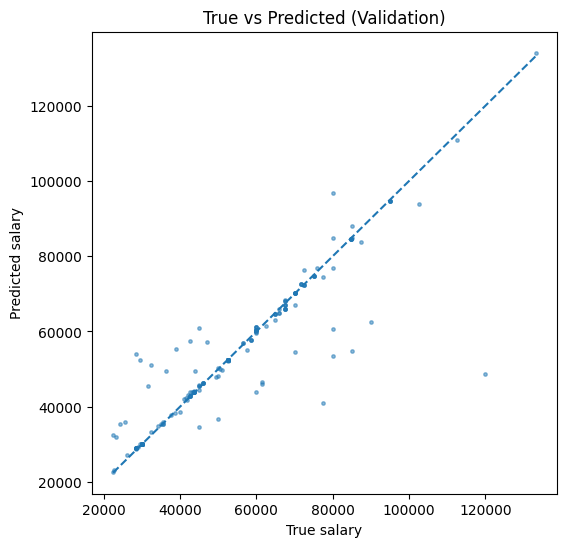

In [ ]:
def inv_transform(yhat):
    if USE_LOG_TARGET:
        return np.exp(yhat)
    return yhat

yhat_valid_t = model.predict(valid_pool_num)
yhat_valid = inv_transform(yhat_valid_t)
y_valid_orig = np.exp(y_valid) if USE_LOG_TARGET else y_valid


print("Validation RMSE:", rmse(y_valid_orig, yhat_valid))
print("Validation MAPE:", mape(y_valid_orig, yhat_valid))

plt.figure(figsize=(6,6))
plt.scatter(y_valid_orig, yhat_valid, s=6, alpha=0.5)
plt.xlabel("True salary")
plt.ylabel("Predicted salary")
plt.title("True vs Predicted (Validation)")
plt.plot([y_valid_orig.min(), y_valid_orig.max()],
         [y_valid_orig.min(), y_valid_orig.max()], linestyle='--')
plt.show()

In [ ]:
shap_vals = model.get_feature_importance(valid_pool_num, type='ShapValues')
feature_names = valid_pool_num.get_feature_names()

shap_main = shap_vals[:, :-1]
expected_vals = shap_vals[:, -1]

mean_abs_shap = np.abs(shap_main).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

shap_df.head(20)

,feature,mean_abs_shap
0,vacancyName,0.047171
1,experienceRequirements,0.039033
944,qualifications__tfidf_838,0.023288
425,qualifications__tfidf_319,0.016750
2213,responsibilities__tfidf_972,0.013409
692,qualifications__tfidf_586,0.012719
2456,responsibilities__tfidf_1215,0.010605
107,qualifications__tfidf_1,0.009852
1332,responsibilities__tfidf_91,0.008269
723,qualifications__tfidf_617,0.007427


In [ ]:
def predict_salary_processed(df_processed):
    model_features = train_pool_num.get_feature_names()
    df_processed = df_processed[model_features]
    pool = make_pool_num(df_processed, None)
    yhat_t = model.predict(pool)
    return inv_transform(yhat_t)

def skill_value_for_row_binarized(row_idx, skill_name, X_processed_df):
    if skill_name not in X_processed_df.columns:
        return None, f"Навык '{skill_name}' не найден в колонках датафрейма. Возможно, он редкий и был отфильтрован."

    x_base = X_processed_df.iloc[[row_idx]].copy()
    base_pred = float(predict_salary_processed(x_base)[0])

    x_minus = x_base.copy()
    x_minus.loc[:, skill_name] = 0
    minus_pred = float(predict_salary_processed(x_minus)[0])

    x_plus = x_base.copy()
    x_plus.loc[:, skill_name] = 1
    plus_pred = float(predict_salary_processed(x_plus)[0])

    value = plus_pred - minus_pred
    delta_plus = plus_pred - base_pred
    delta_minus = base_pred - minus_pred

    return {
        'row_idx': row_idx,
        'skill': skill_name,
        'skill_was_present': bool(x_base[skill_name].iloc[0] == 1),
        'y_base': base_pred,
        'y_minus': minus_pred,
        'y_plus': plus_pred,
        'value_plus_minus': value,
        'delta_plus_vs_base': delta_plus,
        'delta_minus_vs_base': delta_minus
    }, None




In [ ]:
mlb.classes_

array(['1c', '1c (программы семейства 1c)', '1c бухгалтерия',
       '1c зарплата и кадры', '1c предприятие', '1c: бухгалтерия',
       '1c: зарплата и кадры государственного учреждения (зкгу)',
       '1c: зарплата и управление персоналом (зуп) / 1c: зарплата и кадры (зик)',
       '1c: предприятие', '1c: управление нашей фирмой (унф)',
       '1c: управление торговлей (ут) / 1c: торговля и склад (тис)',
       '1c:бухгалтерия', '1c:зарплата и управление персоналом',
       '1c:предприятие', '1c:управление торговлей',
       'active directory (ad)', 'directum',
       'ms office (программы семейства ms office)', 'windows server',
       'автоматизация бизнес-процессов',
       'автоматизация процессов бюджетирования', 'адаптивность',
       'административное управление', 'администрирование',
       'администрирование операционной системы linux',
       'администрирование офиса', 'активное слушание',
       'анализ аудиторских данных', 'анализ бизнес-процессов',
       'анализ бюджетны

In [ ]:
import numpy as np

def skills_in_model():
    mf = set(train_pool_num.get_feature_names())
    return [s for s in skill_cols if s in mf]

def avg_pred_salary(X_df):
    return float(np.mean(predict_salary_processed(X_df)))

BASE_MEAN = avg_pred_salary(X_valid_num)

def avg_uplift_for_skill_missing_only(skill, X_df, sample=1500):
    if skill not in X_df.columns or skill not in train_pool_num.get_feature_names():
        return None
    Xs = X_df[X_df[skill] == 0]
    if len(Xs) == 0:
        return None
    if sample and len(Xs) > sample:
        Xs = Xs.sample(sample, random_state=RANDOM_STATE)
    X_plus = Xs.copy(); X_plus.loc[:, skill] = 1
    uplift = predict_salary_processed(X_plus) - predict_salary_processed(Xs)
    return float(np.mean(uplift)), float(np.median(uplift))

def find_top_addable_skills(X_df, topn=20):
    res = []
    for s in skills_in_model():
        r = avg_uplift_for_skill_missing_only(s, X_df)
        if r is None:
            continue
        mean_up, med_up = r
        res.append((s, mean_up, med_up, mean_up / BASE_MEAN * 100.0))
    res.sort(key=lambda t: t[1], reverse=True)
    return res[:topn]

top_addable = find_top_addable_skills(X_valid_num, topn=20)
for s, mean_up, med_up, pct in top_addable:
    print(f"{s:60s} +{mean_up:,.0f} руб. (медиана {med_up:,.0f}), {pct:.2f}%")

бюджетирование                                               +2,524 руб. (медиана 2,338), 4.77%
организация бухгалтерского учета                             +2,307 руб. (медиана 2,181), 4.36%
управление информационными системами бухгалтерского учета    +1,359 руб. (медиана 1,354), 2.57%
знание бухгалтерского законодательства                       +646 руб. (медиана 726), 1.22%
знание налогового законодательства                           +581 руб. (медиана 742), 1.10%
ведение налогового учета                                     +487 руб. (медиана 481), 0.92%
знание трудового законодательства                            +219 руб. (медиана 246), 0.41%
планирование ресурсов                                        +123 руб. (медиана 231), 0.23%
клиент-банк                                                  +108 руб. (медиана 108), 0.20%
налоговая отчетность                                         +83 руб. (медиана 80), 0.16%
проверка и сверка данных с фондом социального страхования    +82 руб. 

In [ ]:
def top_addable_skills_for_row(row_idx, topn=10):
    skills = [s for s in mlb.classes_ if s in train_pool_num.get_feature_names()]
    x = X_valid_num.iloc[[row_idx]].copy()
    base = float(predict_salary_processed(x)[0])
    gains = []
    for s in skills:
        if s in x.columns and x.at[x.index[0], s] == 0:
            x1 = x.copy(); x1.loc[:, s] = 1
            plus = float(predict_salary_processed(x1)[0])
            gains.append((s, plus - base, (plus - base)/base*100))
    gains.sort(key=lambda t: t[1], reverse=True)
    return gains[:topn]

best_for_row = top_addable_skills_for_row(20, topn=10)
for k, v, pct in best_for_row:
    print(f"{k:60s} +{v:,.0f} руб. ({pct:.2f}%)")

организация бухгалтерского учета                             +4,938 руб. (7.04%)
управление информационными системами бухгалтерского учета    +2,039 руб. (2.90%)
ведение налогового учета                                     +552 руб. (0.79%)
планирование ресурсов                                        +379 руб. (0.54%)
управление бухгалтерским отделом                             +85 руб. (0.12%)
обработка первичной документации                             +71 руб. (0.10%)
проверка и сверка данных с фондом социального страхования    +39 руб. (0.06%)
финансовый анализ                                            +34 руб. (0.05%)
подписание официальных документов                            +26 руб. (0.04%)
подготовка статистических отчетов                            +5 руб. (0.01%)


In [ ]:
skill_shap_df = shap_df[shap_df['feature'].isin(skill_cols)].copy()
skill_shap_df['frequency'] = skill_shap_df['feature'].apply(lambda x: X_train_num[x].sum())
skill_shap_df_filtered = skill_shap_df[skill_shap_df['frequency'] >= 30]
display(skill_shap_df_filtered.sort_values('mean_abs_shap', ascending=False).head(20))

,feature,mean_abs_shap,frequency
36,знание налогового законодательства,0.004524,163
33,знание бухгалтерского законодательства,0.004261,141
27,владение офисным программным обеспечением,0.002156,122
20,ведение налогового учета,0.001526,87
11,1c,0.001322,298
38,знание трудового законодательства,0.000763,62
24,ведение учета/отражение финансово-хозяйственны...,0.000462,154
102,налоговая отчетность,0.000432,151
71,проверка и сверка данных с фондом социального ...,0.000240,65
103,клиент-банк,0.000186,81


In [ ]:
def get_average_skill_value(skill_name, X_processed_df):
    if skill_name not in X_processed_df.columns:
        print(f"Навык '{skill_name}' не найден.")
        return None

    df_minus = X_processed_df.copy()
    df_plus = X_processed_df.copy()

    df_minus[skill_name] = 0
    df_plus[skill_name] = 1

    print(f"Получение предсказаний для '{skill_name}'...")
    preds_minus = predict_salary_processed(df_minus)
    preds_plus = predict_salary_processed(df_plus)

    avg_value = np.mean(preds_plus - preds_minus)
    return avg_value

avg_cost_pc = get_average_skill_value('навыки работы с компьютером', X_valid_num)
print(f"Средняя стоимость навыка 'навыки работы с компьютером': {avg_cost_pc} руб.")

avg_cost_sql = get_average_skill_value('планирование экономической, финансово-хозяйственной деятельности компании', X_valid_num) # Замените на реальный навык из ваших данных
print(f"Средняя стоимость навыка 'формирование и сдача отчетности по заработной плате': {avg_cost_sql} руб.")

Получение предсказаний для 'навыки работы с компьютером'...
Средняя стоимость навыка 'навыки работы с компьютером': 0.0 руб.
Получение предсказаний для 'планирование экономической, финансово-хозяйственной деятельности компании'...
Средняя стоимость навыка 'формирование и сдача отчетности по заработной плате': 6.1705632891237725 руб.


In [ ]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error

def _split_cat_text_cols(X_df, skill_cols):
    base_cols = [c for c in X_df.columns if c not in skill_cols]
    cat_cols, text_cols = [], []
    for c in base_cols:
        if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
            avg_tokens = X_df[c].astype(str).str.split().map(len).mean()
            if avg_tokens and avg_tokens > 10:
                text_cols.append(c)
            else:
                cat_cols.append(c)
    return cat_cols, text_cols

def _coerce_lists_to_str(df_in):
    df = df_in.copy()
    bad = [c for c in df.columns if df[c].apply(lambda v: isinstance(v, (list, tuple, set, dict))).any()]
    if bad:
        for c in bad:
            df[c] = df[c].apply(
                lambda v: ' | '.join(map(str, v)) if isinstance(v, (list, tuple, set))
                else (json.dumps(v, ensure_ascii=False) if isinstance(v, dict) else v)
            )
    return df

def _make_pool_with_cats(X_df, y_vec, cat_cols):
    feature_names = list(X_df.columns)
    cat_idxs = [feature_names.index(c) for c in cat_cols if c in feature_names]
    return Pool(
        data=X_df,
        label=y_vec,
        cat_features=cat_idxs if cat_idxs else None,
        feature_names=feature_names,
    )

def kfold_experiment_processed(X_df, y_vec, skill_cols, n_splits=5,
                               tfidf_max_features=800, tfidf_min_df=10, tfidf_ngram=(1,2)):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    rmses, maes, mapes = [], [], []

    for i, (tr, va) in enumerate(kf.split(X_df), 1):
        trX_raw, vaX_raw = X_df.iloc[tr].copy(), X_df.iloc[va].copy()
        trY, vaY = y_vec.iloc[tr].copy(), y_vec.iloc[va].copy()

        cat_cols, text_cols = _split_cat_text_cols(trX_raw, skill_cols)

        trX, vaX = trX_raw.copy(), vaX_raw.copy()
        for col in text_cols:
            vec = TfidfVectorizer(max_features=tfidf_max_features,
                                  ngram_range=tfidf_ngram, min_df=tfidf_min_df)
            Xt = vec.fit_transform(trX[col].fillna(""))
            Xv = vec.transform(vaX[col].fillna(""))

            tf_cols = [f"{col}__tfidf_{j}" for j in range(Xt.shape[1])]
            trX_tfidf = pd.DataFrame(Xt.toarray(), index=trX.index, columns=tf_cols)
            vaX_tfidf = pd.DataFrame(Xv.toarray(), index=vaX.index, columns=tf_cols)

            trX = pd.concat([trX.drop(columns=[col]), trX_tfidf], axis=1)
            vaX = pd.concat([vaX.drop(columns=[col]), vaX_tfidf], axis=1)

        trX = _coerce_lists_to_str(trX)
        vaX = _coerce_lists_to_str(vaX)

        tr_pool = _make_pool_with_cats(trX, trY, cat_cols)
        va_pool = _make_pool_with_cats(vaX, vaY, cat_cols)

        model_cv = CatBoostRegressor(**params)
        model_cv.fit(tr_pool, eval_set=va_pool, verbose=False)

        yhat_t = model_cv.predict(va_pool)
        yhat = inv_transform(yhat_t)
        y_true = inv_transform(vaY)

        rmses.append(rmse(y_true, yhat))
        maes.append(mean_absolute_error(y_true, yhat))
        mapes.append(mape(y_true, yhat))

        print(f"Fold {i}: RMSE={rmses[-1]:,.0f} | MAE={maes[-1]:,.0f} | MAPE={mapes[-1]:.4f}")

    print("KFold RMSE mean±std:", f"{np.mean(rmses):,.0f}", f"± {np.std(rmses):,.0f}")
    print("KFold MAE  mean±std:", f"{np.mean(maes):,.0f}",  f"± {np.std(maes):,.0f}")
    print("KFold MAPE mean±std:", f"{np.mean(mapes):.4f}",   f"± {np.std(mapes):.4f}")

In [ ]:
# skill_cols = skills_df_use.columns.tolist()
kfold_experiment_processed(X_processed, y_transformed, skill_cols, n_splits=5)

/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 1: RMSE=8,173 | MAE=2,888 | MAPE=0.0563


/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 2: RMSE=8,572 | MAE=3,414 | MAPE=0.0685


/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 3: RMSE=8,754 | MAE=3,754 | MAPE=0.0775


/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 4: RMSE=10,037 | MAE=3,349 | MAPE=0.0686


/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 5: RMSE=11,378 | MAE=4,089 | MAPE=0.0773
KFold RMSE mean±std: 9,383 ± 1,177
KFold MAE  mean±std: 3,499 ± 404
KFold MAPE mean±std: 0.0696 ± 0.0078
